In [1]:
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from liesel_sparse import band

In [2]:
% % capture
# Import my GP
% run./ GP.ipynb

In [3]:
#plt.style.use('bmh')
plt.style.use("seaborn-v0_8-muted")

In [4]:
# /textwidth 472.31595pt.
# \OT1/cmr/m/n/10.95=select font cmr10 at 10.95pt
# \textfont a (a): cmmi10 at 10.95pt
# \scriptfont a (a): cmmi8
# \textfont \alpha (α): cmmi10 at 10.95pt
# \textfont \cap (∩): cmsy10 at 10.95pt
# \textfont = (=): cmr10 at 10.95pt

def set_size(width_pt=472.31595, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in


colors = ["white", "#005f9b", "#153268"]
nodes = [0.0, 0.8, 1.0]
unimap = matplotlib.colors.LinearSegmentedColormap.from_list("unimap", list(zip(nodes, colors)))
unimap_r = unimap.reversed()
try:
    matplotlib.colormaps.register(cmap=unimap)
    matplotlib.colormaps.register(cmap=unimap_r)
except ValueError:
    pass

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "font.serif": "Computer Modern Roman",
    "text.usetex": True,  # use inline math for ticks
    "text.latex.preamble": r"\usepackage{amsmath}",
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10.95,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # Cmap
    "image.cmap": "unimap"
})

### Kernel Matrix

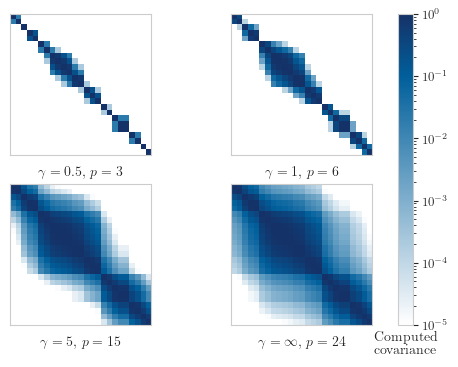

In [5]:
rng = np.random.RandomState(2)
toy_X = jnp.sort(rng.choice(jnp.linspace(0, 10, 100), 25))

fig, axs = plt.subplots(2, 2, figsize=set_size(fraction=1, subplots=(2, 2)))

for i, ax in enumerate(axs.flat):
    thetas = [0.5, 1, 5, float("inf")]
    k = lambda *args: MaternKernel32(1, 0.7, *args) * WendlandTapering(3, thetas[i], *args)
    K = cov_matrix(toy_X, toy_X, k)

    thetas[-1] = r"\infty"
    im = ax.matshow(K, norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1))
    ax.set_xlabel(rf"$\gamma = {thetas[i]}$, $p = {band.bandwidth(K)}$")
    ax.get_xaxis().set_ticks([]);
    ax.get_yaxis().set_ticks([])

clb = fig.colorbar(im, ax=axs.ravel().tolist())
clb.ax.set_xlabel("Computed\n covariance")
plt.show()
fig.savefig('wendlands.pdf', format='pdf', bbox_inches='tight')

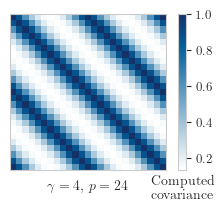

In [6]:
rng = np.random.RandomState(2)
#toy_X = jnp.sort(rng.choice(jnp.linspace(0, 10, 100), 25))
toy_X = jnp.linspace(0, 10, 25)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))

k = lambda *args: ExpSineSquaredKernel(1, 1, 5, *args)  # * WendlandTapering(3, 3, *args)
K = cov_matrix(toy_X, toy_X, k)

im = ax.matshow(K)  #, norm=matplotlib.colors.LogNorm(vmax=1))
ax.set_xlabel(rf"$\gamma = 4$, $p = {band.bandwidth(K)}$")
ax.get_xaxis().set_ticks([]);
ax.get_yaxis().set_ticks([])

clb = fig.colorbar(im, ax=ax)
clb.ax.set_xlabel("Computed\n covariance")
plt.show()
fig.savefig('kernel.pdf', format='pdf', bbox_inches='tight')

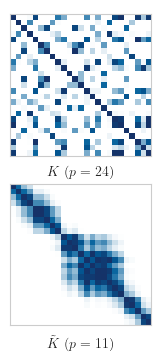

In [7]:
rng = np.random.RandomState(2)
toy_X = rng.choice(jnp.linspace(0, 10, 100), 25)

fig, axs = plt.subplots(2, 1, figsize=set_size(fraction=.5, subplots=(2, 1)))

for i, ax in enumerate(axs.flat):
    k = lambda *args: MaternKernel32(1, 5, *args) * WendlandTapering(3, 3, *args)
    K = cov_matrix(toy_X, toy_X, k)
    if i:
        K, _ = band.permute(K)

    im = ax.matshow(K)
    ax.set_xlabel(rf"$K\ (p = {band.bandwidth(K)})$" if not i else
                  r"$\tilde{K}\ " + rf"(p = {band.bandwidth(K)})$")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()
fig.savefig('cuthill.pdf', format='pdf', bbox_inches='tight')

## Kernel graph

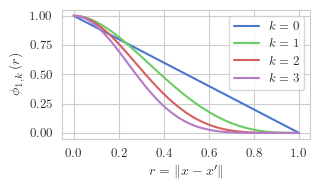

In [8]:
rng = np.random.RandomState(2)
r = jnp.linspace(0, 1, 100)

fig, axs = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))
#plt.subplots_adjust(bottom=-0.1)

for k in [0, 1, 2, 3]:
    y = jax.vmap(lambda y_: WendlandTapering(k, 1, y_, 0))(r)
    im = axs.plot(r, y, label=f"$k = {k}$")

plt.gca().set_xlabel(r"$r = \lVert x - x' \rVert$")
plt.gca().set_ylabel(r"$\phi_{1, k}\left(r\right)$")
axs.legend()

plt.tight_layout()
plt.show()
fig.savefig('wendlandsr.pdf', format='pdf', bbox_inches='tight')

## Draw Functions (prior)

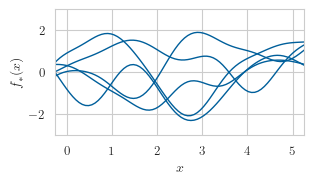

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel_ = RBF(length_scale=0.7)
gpr_model = GaussianProcessRegressor(kernel=kernel_)
n_samples = 5

x = np.linspace(-1, 6, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, n_samples, random_state=2)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))

for idx, single_prior in enumerate(y_samples.T):
    ax.plot(x, single_prior, alpha=1, lw=1, c=unimap(0.8))

ax.set_xlabel("$x$")
ax.set_ylabel("$f_*(x)$")
ax.set_xlim([-0.25, 5.25])
ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()
fig.savefig('drawprior.pdf', format='pdf', bbox_inches='tight')

## Draw Functions (posterior, no noise)

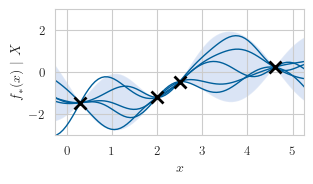

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel_ = RBF(length_scale=0.7)
gpr_model = GaussianProcessRegressor(kernel=kernel_, optimizer=None, alpha=0)
n = 4
x_points = np.array([0.3, 2, 2.5, 4.6]).reshape(-1, 1)
y_points = np.random.rand(n) * 3 - 3 / 2
gpr_model.fit(x_points, y_points)

n_samples = 5

x = np.linspace(-1, 6, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, n_samples, random_state=5)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))
plt.plot(x_points, y_points, marker="x", lw=0, mew=2, ms=8, alpha=1, zorder=5, c='k')

for idx, single_prior in enumerate(y_samples.T):
    ax.plot(x, single_prior, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(0.8))

pred_mean, pred_var = gpr_model.predict(X, return_std=True)
ax.fill_between(x, pred_mean - 1.96 * pred_var, pred_mean + 1.96 * pred_var, alpha=0.2, zorder=-1)

ax.set_xlabel("$x$")
ax.set_ylabel("$f_*(x)\ |\ X$")
ax.set_xlim([-0.25, 5.25])
ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()
fig.savefig('drawposterior.pdf', format='pdf', bbox_inches='tight')

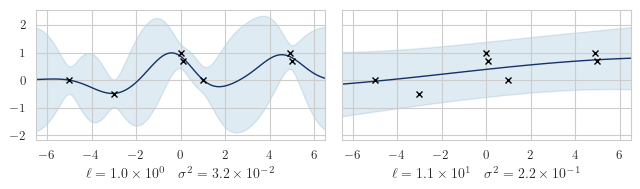

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from num2tex import num2tex

fig, axs = plt.subplots(1, 2, figsize=set_size(fraction=1, subplots=(1, 2)), sharey="all")

X_train = np.array([-5, -3, 0, .1, 1, 4.9, 5]).reshape(-1, 1)
x = np.linspace(-7, 7, 100)
y_train = np.array([0, -.5, 1, .7, 0, 1, .7])

opts = list()

for i, ax in enumerate(axs.flat):
    if i == 0:
        kernel = RBF(1) + WhiteKernel(1)
    else:
        kernel = RBF(10) + WhiteKernel(1e-1)

    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=0)
    gpr.fit(X_train, y_train)
    pred_mean, pred_var = gpr.predict(x.reshape(-1, 1), return_std=True)
    ax.plot(x, pred_mean, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(1.0))
    ax.fill_between(x, pred_mean - 1.96 * pred_var, pred_mean + 1.96 * pred_var, alpha=0.2, zorder=-1,
                    color=matplotlib.cm.get_cmap("unimap")(.5))
    ax.plot(X_train, y_train, marker="x", lw=0, mew=1, ms=4, alpha=1, zorder=5, c='k')
    ax.set_xlabel("$\ell = {:.1e}\quad".format(num2tex(np.exp(gpr.kernel_.theta[0]))) +
                  "\sigma^2 = {:.1e}$".format(num2tex(np.exp(gpr.kernel_.theta[1]))))
    ax.set_xlim([-6.5, 6.5])

    opts.append(np.exp(gpr.kernel_.theta))

plt.tight_layout()
plt.show()
fig.savefig('optima.pdf', format='pdf', bbox_inches='tight', dpi=300)

## Contour

5.734802786716455 591.4438104119218


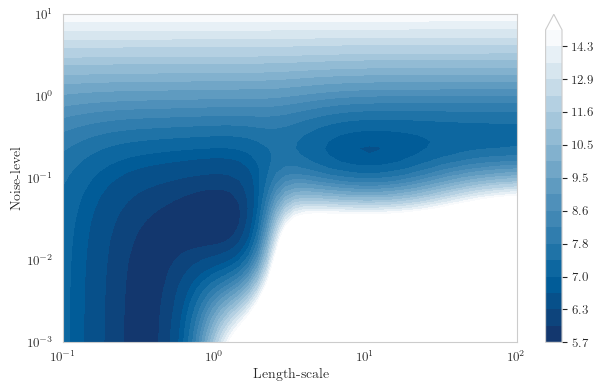

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

X_train = np.array([-5, -3, 0, .1, 1, 4.9, 5]).reshape(-1, 1)
y_train = np.array([0, -.5, 1, .7, 0, 1, .7])

kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gpr.fit(X_train, y_train)

length_scale = np.logspace(-1, 2, num=50)
noise_level = np.logspace(-3, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
print(vmin, vmax)
vmax = 15
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=20), decimals=1)
im = ax.contourf(
    length_scale_grid, noise_level_grid, -log_marginal_likelihood,
    levels=level, norm=LogNorm(), cmap="unimap_r", extend="max", antialiased=False
)

plt.colorbar(im, extend='max')
plt.xscale("log");
plt.yscale("log")
plt.xlabel("Length-scale");
plt.ylabel("Noise-level")
plt.tight_layout()
plt.show()
fig.savefig('contour.pdf', format='pdf', bbox_inches='tight', dpi=300)

## Contour (L-BFGS-B)

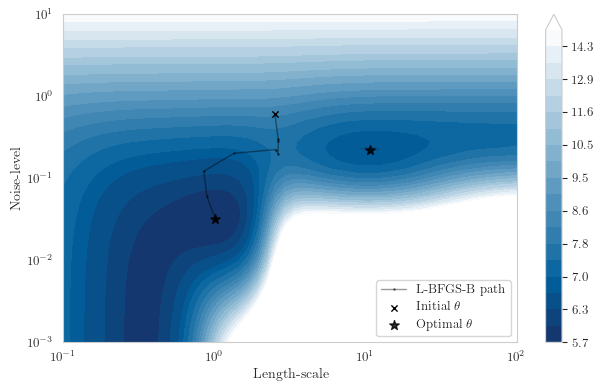

In [82]:

from sklearn.gaussian_process.kernels import *
from matplotlib.colors import LogNorm
from scipy import optimize

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))


def obj_func(theta):
    lml, grad = gpr.log_marginal_likelihood(np.log(theta), eval_gradient=True, clone_kernel=False)
    return -lml, -grad


x0 = [2.5, 0.6]
path = [x0]

res = optimize.minimize(fun=obj_func, x0=x0, bounds=[(1e-1, 1e2), (1e-3, 1e1)], method="L-BFGS-B", jac=True,
                        callback=lambda xk: path.append(np.copy(xk)), tol=1e-3)

# ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
#           scale_units='xy', angles='xy', scale=1.2, color='k', zorder=10, alpha=.6,
#           width = .003)
ax.plot(*np.array(path).T, zorder=10, alpha=.4, c="k", marker="o", markersize=1, linewidth=1, label="L-BFGS-B path")
ax.scatter(*x0, marker="x", s=20, lw=1, c="k", label=r"Initial $\theta$", zorder=20)
ax.scatter(*zip(opts[0], opts[1]), marker="*", s=50, c="k", alpha=.8, label=r"Optimal $\theta$", zorder=20)

im = ax.contourf(
    length_scale_grid, noise_level_grid, -log_marginal_likelihood,
    levels=level, norm=LogNorm(), cmap="unimap_r", extend="max"
)

ax.legend(loc='lower right')
plt.colorbar(im, extend='max')
plt.xscale("log");plt.yscale("log")
plt.xlabel("Length-scale");plt.ylabel("Noise-level")
plt.tight_layout()
plt.show()
fig.savefig('contourlbfgsb.pdf', format='pdf', bbox_inches='tight', dpi=300)